In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
!gdown --id 1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
!gdown --id 1bs8PHTExPfItW636-HVRVYwjjPilQVgy

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
To: /content/id_map.parquet
100% 1.20M/1.20M [00:00<00:00, 72.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
To: /content/train.csv
42.9MB [00:00, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1bs8PHTExPfItW636-HVRVYwjjPilQVgy
To: /content/test.csv
24.8MB [00:00, 91.7MB/s]


In [98]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 50 kB/s 


In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [71]:
def time_features_extraction(data):

    data = data.assign(
            # avg hour of day in a session
            avg_hour=lambda x: np.round(x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1)),
            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
            # avg month of session
            avg_month=lambda x: x.filter(like='time').apply(lambda x: x.dt.month).mean(axis=1)
        )

    for i in range(1,10):
        data["delta"+str(i)] = (data["time" + str(i+1)] - data["time" + str(i)]).dt.seconds
    
    data.drop(columns=[f'time{i+1}' for i in range(10)], inplace=True)

    data = data.assign(
        sum_time=lambda x: x.filter(like="delta").sum(axis=1)
    )
    data.loc[data["sum_time"]==0, "sum_time"] = 0.01

    
    data.drop(columns=["delta"+str(i) for i in range(1, 10)], inplace=True)

    return data

In [72]:
def unique_features(domain_features):
    n_unique = domain_features.assign(
        nans_count=lambda x: x.filter(like='webpage').isna().sum(axis=1),
        # number of unique pages in session
        n_unique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count))
    return n_unique

In [73]:
def dist_graph(data, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")
        return data.loc[:, target_col], 1

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

In [74]:
def target_distr(data, target):
    ncount = len(data)

    fig = plt.figure(figsize=(12,5))
    ax = sns.countplot(x=target, data=data.loc[:, [target]])

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate(f'{100.*y/ncount:.1f}% ({int(y)} obs)', (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.xlabel("categories")
    plt.ylabel("objects")
    plt.title('Distribution of Classes')
    plt.tight_layout()

    plt.show()

In [75]:
x_train = pd.read_csv("./train.csv", parse_dates=[f'time{i+1}' for i in range(10)])
x_test = pd.read_csv('./test.csv', parse_dates=[f'time{i+1}' for i in range(10)])
id_map = pd.read_parquet("/content/id_map.parquet")

In [76]:
x_train = unique_features(x_train)
x_test = unique_features(x_test)

x_train.drop(columns=[f'webpage{i+1}' for i in range(10)], inplace=True)
x_test.drop(columns=[f'webpage{i+1}' for i in range(10)], inplace=True)

x_train = time_features_extraction(x_train)
x_test = time_features_extraction(x_test)

# target

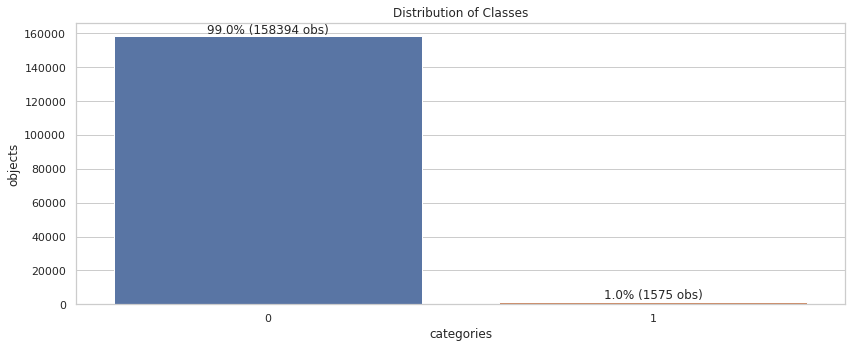

In [12]:
target_distr(data=x_train, target="target")

# sum_time

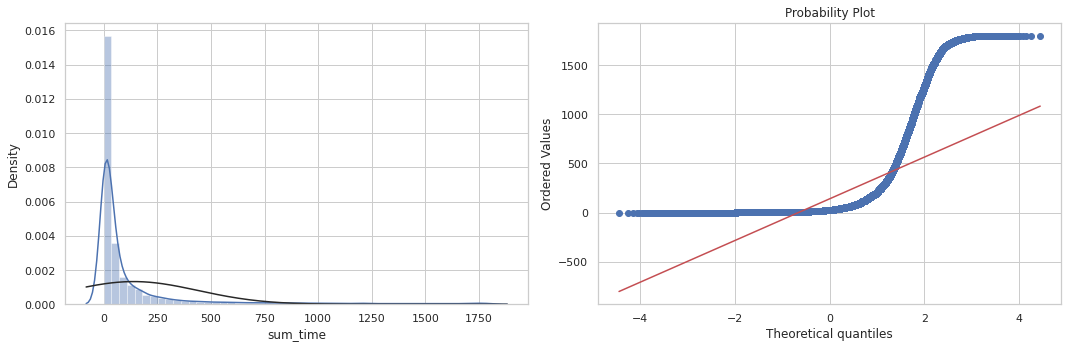

Skewness: 3.417982
Kurtosis: 12.211970 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 112242.39715218177
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


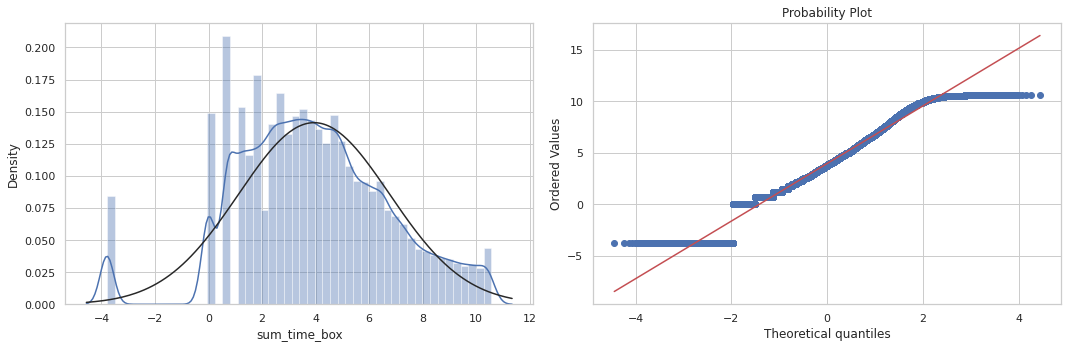

Skewness: 0.021876
Kurtosis: 0.218479 

null hypothesis: x comes from a normal distribution
p_value = 6.929923456520416e-60, 272.43851362347414
The null hypothesis still can be rejected
But we did our best


In [30]:
x_train["sum_time"], b = dist_graph(data=x_train.copy(), target_col="sum_time")

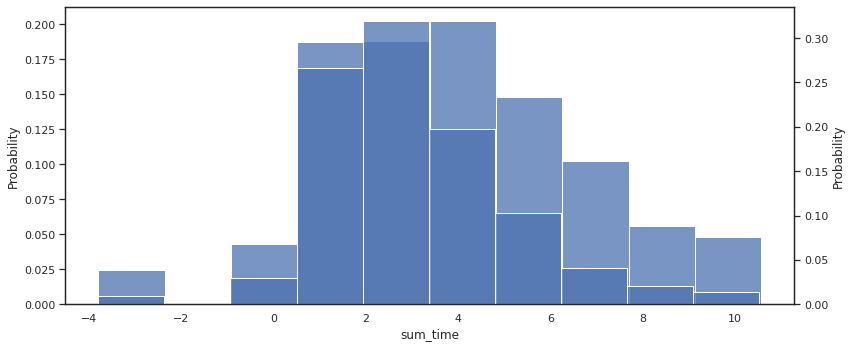

In [38]:
fig, ax1 = plt.subplots(figsize=(12,5))
sns.histplot(x="sum_time", data=x_train.loc[x_train["target"]==0, ["sum_time"]], stat="probability", bins=10)
ax2 = ax1.twinx()
sns.histplot(x="sum_time", data=x_train.loc[x_train["target"]==1, ["sum_time"]], stat="probability", bins=10)
plt.tight_layout()
plt.show()

In [ ]:
sample1 = x_train.loc[x_train["target"] == 1, "sum_time"].values
sample2 = x_train.loc[x_train["target"] == 0, "sum_time"].values

In [ ]:
# The result of non-parametric The Kruskal-Wallis H-test
stats.kruskal(sample1, sample2)

KruskalResult(statistic=202.97277017932507, pvalue=4.6895395804321275e-46)

# n_unique_pages

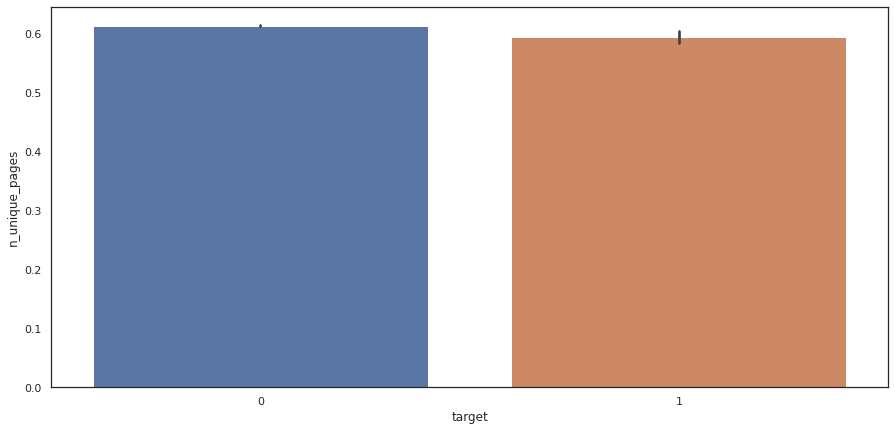

In [50]:
fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x="target", y="n_unique_pages", data=x_train)
plt.show()

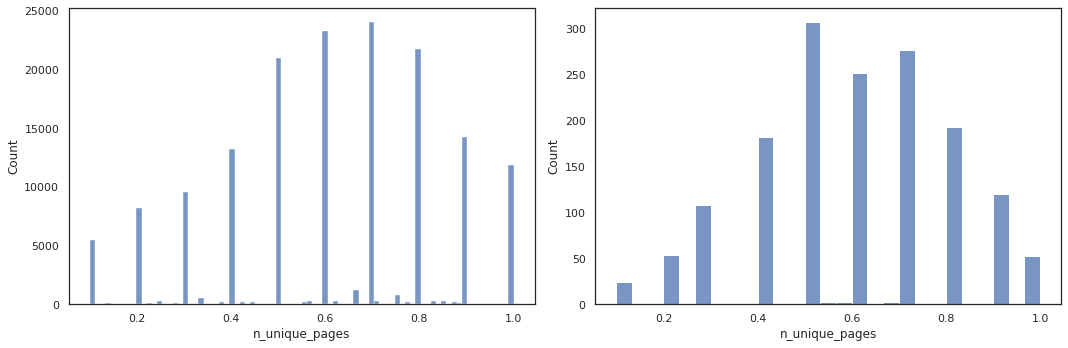

In [66]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(x="n_unique_pages", data=x_train.loc[x_train["target"]==0, ["n_unique_pages"]], ax=axes[0])
sns.histplot(x="n_unique_pages", data=x_train.loc[x_train["target"]==1, ["n_unique_pages"]], ax=axes[1])
plt.tight_layout()
plt.show()

# nans_count

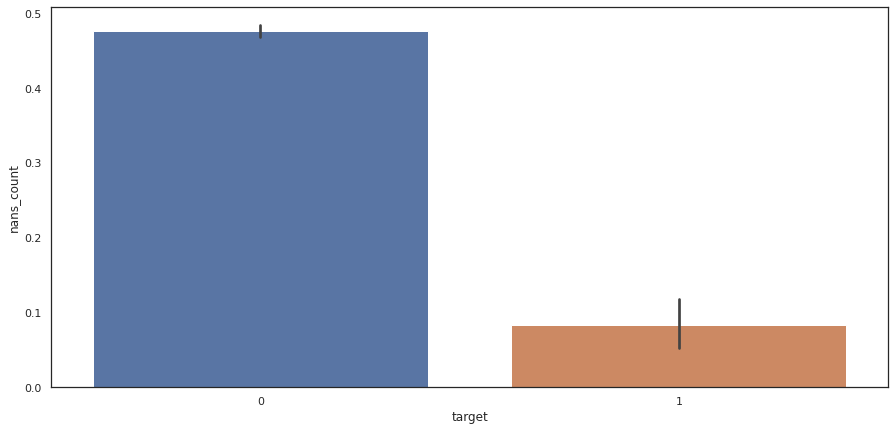

In [51]:
fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x="target", y="nans_count", data=x_train)
plt.show()

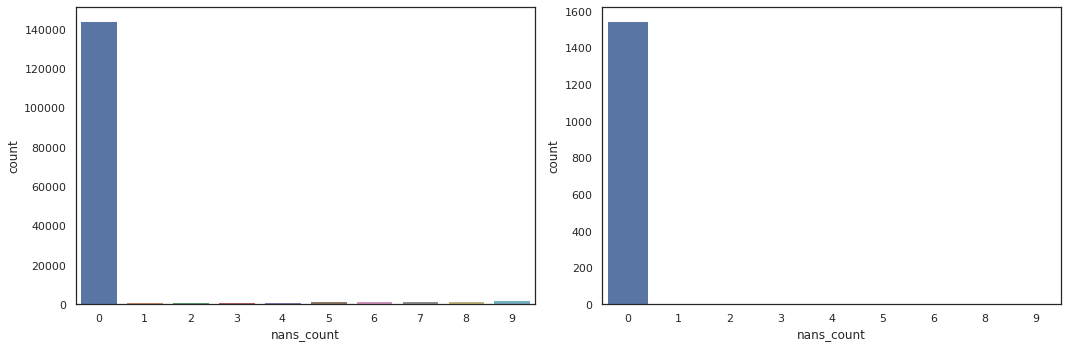

In [67]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x="nans_count", data=x_train.loc[x_train["target"]==0, ["nans_count"]], ax=axes[0])
sns.countplot(x="nans_count", data=x_train.loc[x_train["target"]==1, ["nans_count"]], ax=axes[1])
plt.tight_layout()
plt.show()

# avg_hour

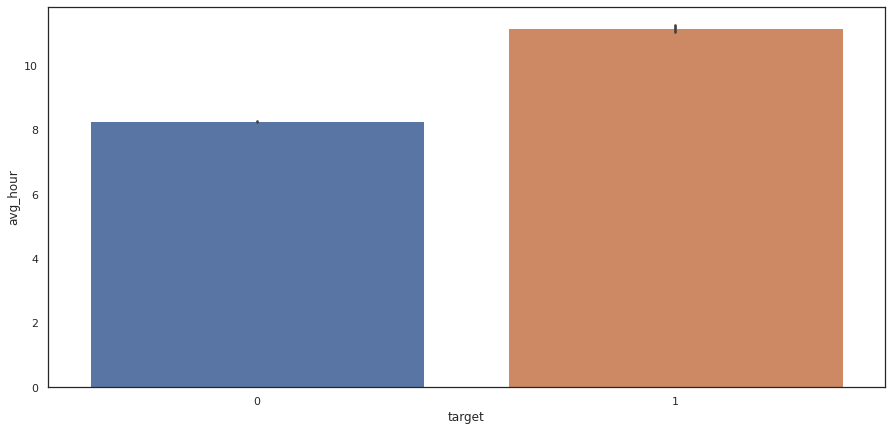

In [52]:
fig = plt.figure(figsize=(15,7))
ax = sns.barplot(x="target", y="avg_hour", data=x_train)
plt.show()

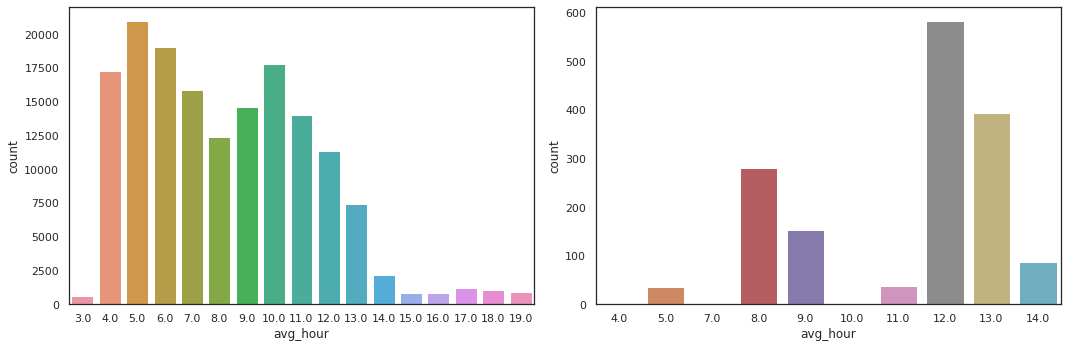

In [68]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x="avg_hour", data=x_train.loc[x_train["target"]==0, ["avg_hour"]], ax=axes[0])
sns.countplot(x="avg_hour", data=x_train.loc[x_train["target"]==1, ["avg_hour"]], ax=axes[1])
plt.tight_layout()
plt.show()

# avg_day

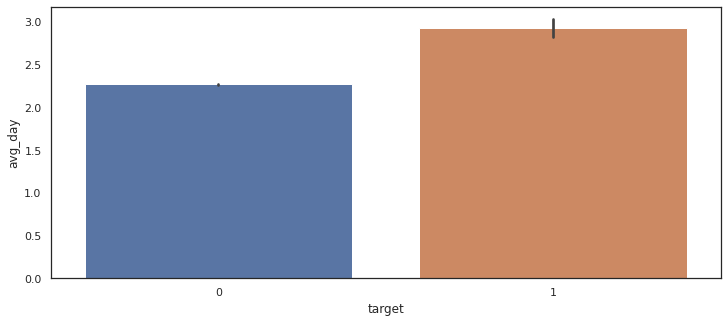

In [62]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="target", y="avg_day", data=x_train)
plt.show()

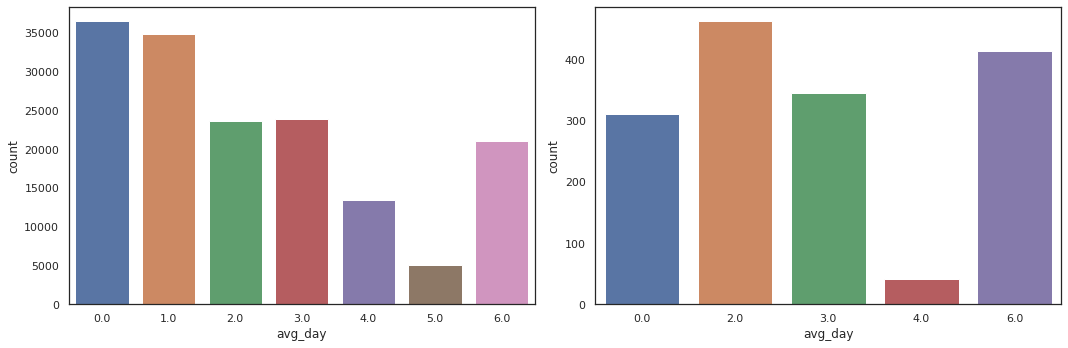

In [69]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x="avg_day", data=x_train.loc[x_train["target"]==0, ["avg_day"]], ax=axes[0])
sns.countplot(x="avg_day", data=x_train.loc[x_train["target"]==1, ["avg_day"]], ax=axes[1])
plt.tight_layout()
plt.show()

# avg_month

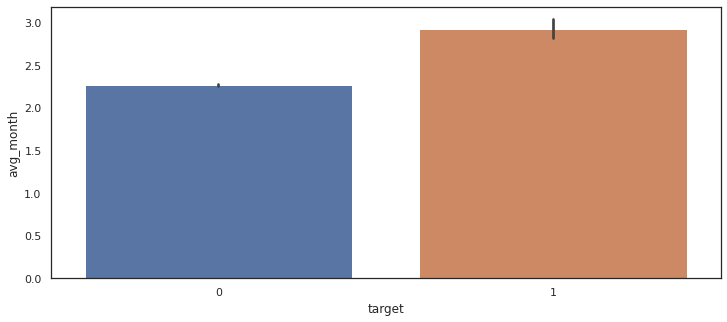

In [61]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="target", y="avg_month", data=x_train)
plt.show()

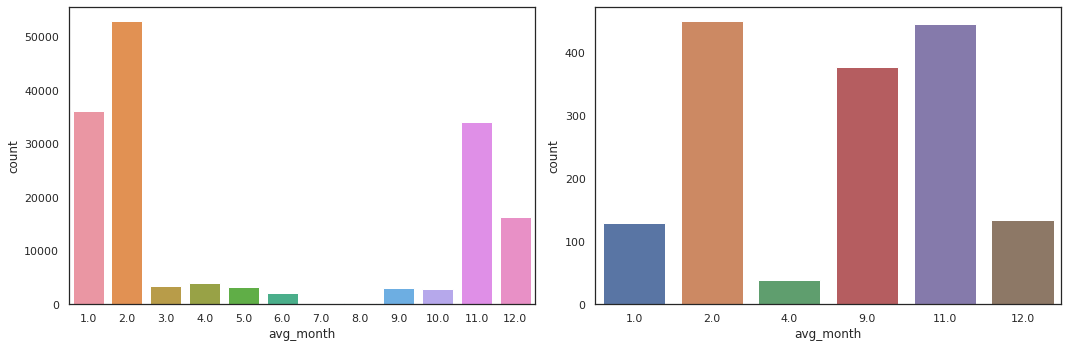

In [77]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x="avg_month", data=x_train.loc[x_train["target"]==0, ["avg_month"]], ax=axes[0])
sns.countplot(x="avg_month", data=x_train.loc[x_train["target"]==1, ["avg_month"]], ax=axes[1])
plt.tight_layout()
plt.show()

In [79]:
x_train.drop(columns=["session_id"], inplace=True)

In [123]:
train_set, y_train = x_train.drop(columns=["target"]), x_train.loc[:, "target"]

In [121]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.pipeline import Pipeline as imb_make_pipeline
from imblearn.over_sampling import SMOTE

In [124]:
sm = SMOTE(random_state=42, k_neighbors=7, sampling_strategy=0.20)
train_resampled, y_train_resampled = sm.fit_resample(train_set, y_train)

In [138]:
model = LGBMClassifier(random_state=42)
tscv = TimeSeriesSplit()
n_scores = cross_val_score(model, train_resampled, y=y_train_resampled, scoring='roc_auc', cv=tscv, n_jobs=-1)
# report performance
print('roc_auc: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print(n_scores)

Accuracy: 0.970 (0.007)
[0.95943697 0.972977   0.97555591 0.97688296 0.96637241]


In [140]:
model.fit(train_resampled, y_train_resampled)
predicts = model.predict(train_resampled)
print(classification_report(y_train_resampled, predicts))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158394
           1       0.96      0.95      0.96     31678

    accuracy                           0.99    190072
   macro avg       0.97      0.97      0.97    190072
weighted avg       0.99      0.99      0.99    190072



In [141]:
model = CatBoostClassifier(learning_rate=0.03, depth=8, l2_leaf_reg=3, iterations=200, 
                           auto_class_weights = "Balanced", loss_function = "Logloss", 
                           random_state=42, silent=True)
tscv = TimeSeriesSplit()
n_scores = cross_val_score(model, train_resampled, y=y_train_resampled, scoring='roc_auc', cv=tscv, n_jobs=-1)
# report performance
print('roc_auc: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print(n_scores)

f1_micro: 0.975 (0.005)
[0.97290745 0.97823054 0.9756365  0.98005477 0.96660798]


In [142]:
model.fit(train_resampled, y_train_resampled)
predicts = model.predict(train_resampled)
print(classification_report(y_train_resampled, predicts))

0:	learn: 0.6502533	total: 86.2ms	remaining: 17.2s
1:	learn: 0.6138953	total: 173ms	remaining: 17.1s
2:	learn: 0.5798735	total: 256ms	remaining: 16.8s
3:	learn: 0.5534200	total: 345ms	remaining: 16.9s
4:	learn: 0.5251742	total: 426ms	remaining: 16.6s
5:	learn: 0.5039319	total: 518ms	remaining: 16.7s
6:	learn: 0.4821013	total: 608ms	remaining: 16.8s
7:	learn: 0.4636884	total: 689ms	remaining: 16.5s
8:	learn: 0.4460139	total: 774ms	remaining: 16.4s
9:	learn: 0.4325491	total: 861ms	remaining: 16.4s
10:	learn: 0.4191993	total: 943ms	remaining: 16.2s
11:	learn: 0.4040232	total: 1.03s	remaining: 16.1s
12:	learn: 0.3884076	total: 1.11s	remaining: 16s
13:	learn: 0.3772049	total: 1.2s	remaining: 15.9s
14:	learn: 0.3653810	total: 1.28s	remaining: 15.8s
15:	learn: 0.3545861	total: 1.37s	remaining: 15.8s
16:	learn: 0.3452835	total: 1.46s	remaining: 15.7s
17:	learn: 0.3365410	total: 1.55s	remaining: 15.7s
18:	learn: 0.3285767	total: 1.64s	remaining: 15.6s
19:	learn: 0.3218090	total: 1.73s	remaining

In [143]:
model = XGBClassifier(random_state=42, scale_pos_weight=5, n_estimators=150)
tscv = TimeSeriesSplit()
n_scores = cross_val_score(model, train_resampled, y=y_train_resampled, scoring='roc_auc', cv=tscv, n_jobs=-1)
# report performance
print('roc_auc: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
n_scores

f1_micro: 0.962 (0.006)


array([0.96106548, 0.96913115, 0.96408675, 0.96410991, 0.95243387])

In [144]:
model.fit(train_resampled, y_train_resampled)
predicts = model.predict(train_resampled)
print(classification_report(y_train_resampled, predicts))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    158394
           1       0.75      0.98      0.85     31678

    accuracy                           0.94    190072
   macro avg       0.87      0.96      0.91    190072
weighted avg       0.95      0.94      0.94    190072

